# Clip for visual grounding

## Data loading from drive and extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !mkdir dataset
# !pip install gdown
# !gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
# !mv refcocog.tar.gz ./dataset/
# !ls dataset

In [ ]:
import tarfile
# data_dir='/content/dataset/refcocog.tar.gz'
data_dir='/content/drive/MyDrive/refcocog.tar.gz'
# data_dir='/home/disi/refcocog'
# Extract data
tar = tarfile.open(data_dir)
tar.extractall()

## Installing Clip and Yolov5 repository for baseline and other usage

In [1]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2elzcqdj
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-2elzcqdj
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=4450eb8acf241c14b124d3abc77b026595d7480a51c22093293e6bdfb09c050d
  Stored in directory: /tmp/pip-ephem-wheel-cache-kietxam9/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

#Baseline with yolov5 without training

All dependency or packages import

In [2]:
import cv2
import os, clip
from PIL import Image
import torch
import torch.nn as nn
import pickle, json
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision
from torchvision.utils import draw_bounding_boxes
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import torch.nn.functional as F
import albumentations as A
import numpy as np
import gc
to_pil = transforms.ToPILImage()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load('RN50')
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/disi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-10 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
class CFG:
  def __init__(self, size, iou_thres, batch_size, test_batch_size, epoch):
    self.size = size
    self.iou_thres = iou_thres
    self.batch_size = batch_size
    self.test_batch_size = test_batch_size
    self.epoch = epoch

config = CFG(640, 0.5, 5, 5, 20)

## Custom Dataset class for RefCOCOg
In order to load data correctly, we needed to deal with bounding boxes, images and captions. We only took the first sentence of captions and transformed images to fixed size. When transforming image to certain size we need to also resize the bounding boxes. In the following code there is two functions for transforming bounding boxes.

1.   resize_bounding_box : resizes bounding box based on original image size and resized image size
2.   xywh_to_xyxy : in the dataset, bounding box format is x, y, width, height. But our model returns x min, y min, x max, y max. So we convert the targeted bounding box to same format as model.



In [5]:
transform = A.Compose([
                A.Resize(config.size, config.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
])

def resize_bounding_box(bbox, original_size, new_size):
    x_min, y_min, x_max, y_max = bbox
    orig_height, orig_width, _ = original_size
    new_width, new_height = new_size

    # Calculate the scaling factors
    width_ratio = new_width / orig_width
    height_ratio = new_height / orig_height

    # Resize the bounding box coordinates
    new_x_min = int(x_min * width_ratio)
    new_y_min = int(y_min * height_ratio)
    new_x_max = int(x_max * width_ratio)
    new_y_max = int(y_max * height_ratio)

    return new_x_min, new_y_min, new_x_max, new_y_max

def xywh_to_xyxy(boxes):
    xmin = boxes[0]
    ymin = boxes[1]
    w = boxes[2]
    h = boxes[3]
    xmax = xmin + w
    ymax = ymin + h
    return [xmin, ymin, xmax, ymax]


class RefCOCOgDataset(Dataset):
  def __init__(self, transform = None):
    super(RefCOCOgDataset, self).__init__()
    self.images = []
    self.descriptions = []
    self.bboxes = []

    f = open('refcocog/annotations/refs(umd).p', 'rb')
    self.data = pickle.load(f)
    instances_file = os.path.join('refcocog/annotations/instances.json')
    instances = json.load(open(instances_file, 'r'))
    self.insta = instances
    cnt = 0
    for item in self.data:
      self.descriptions.append(item['sentences'])
      cnt = cnt+1
      for c in instances['images']:
        if c['id'] == item['image_id']:
            self.images.append(c['file_name'])
            break
      for c in instances['annotations']:
        if c['id'] == item['ann_id']:
            self.bboxes.append(c['bbox'])
            break
      # for the sake of running faster we fixed the size of dataset temporarily
      if cnt > 100:
        break
    self.transform = transform

  def __getitem__(self, idx):

    img_path = f'refcocog/images/{self.images[idx]}'
    image = cv2.imread(img_path)
    shape_0 = list(image.shape)
    if (self.transform is not None):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = self.transform(image=image)['image']
      image = torch.tensor(image).permute(2, 0, 1).float()

    labels = [x['raw'] for x in self.descriptions[idx]]
    text_inputs = clip.tokenize(f"a photo of a {labels[0]}")
    bbox = resize_bounding_box(xywh_to_xyxy(self.bboxes[idx]), shape_0, [640,640])
    bbox = torch.tensor(bbox)
    return image, text_inputs[0], bbox

  def __len__(self):
    return len(self.images)


In [ ]:
dataset = RefCOCOgDataset()

## Baseline method

Baseline function computes the visual grounding using yolov5 model and Clip. Yolov5 suggests certain bounding box predictions. Then we transform it to Clip format and pass it to Clip to get the similarity score. Then the top first element would be our desired result.

In [ ]:
def baseline(x):
    image = x[0]
    captions = x[1]
    result = yolo(image)
    bboxes = result.crop(save=False)
    im_features = []
    for bbox in bboxes:
        image_input = preprocess(Image.fromarray(bbox['im'])).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        im_features.append(image_features)
    if len(bboxes) == 0:
      return 0, torch.zeros(4)
    text_inputs = captions.unsqueeze(0).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)

    text_features /= text_features.norm(dim=-1, keepdim=True)
    im_features = torch.stack(im_features)
    similarity = (100.0 * im_features @ text_features.T).softmax(dim=0)
    top_values, top_indices = similarity.topk(1, dim=0)
    t = to_pil(bboxes[top_indices]['im'])
    t.show()
    return top_values.item(), bboxes[top_indices]['box']

### Baseline metrics
We tried to measure the baseline results by Intersection over Union function. After running the baseline method we get the all predicted bounding boxes. Based on that results, we calculate precision and recall in order to get the average or mean average precission.

In [ ]:
def calculate_iou1d(box1, box2):
    # Calculate coordinates of intersection rectangle
  x1_1 = box1[0]
  y1_1 = box1[1]
  x2_1 = box1[2]
  y2_1 = box1[3]

  x1_2 = box2[0]
  y1_2 = box2[1]
  x2_2 = box2[2]
  y2_2 = box2[3]

  intersection_width = min(x2_1, x2_2) - max(x1_1, x1_2)
  intersection_height = min(y2_1, y2_2) - max(y1_1, y1_2)

  if intersection_width > 0 and intersection_height > 0:
      area_of_intersection = intersection_width * intersection_height
  else:
      area_of_intersection = 0

  area_of_box1 = (x2_1 - x1_1) * (y2_1 - y1_1)
  area_of_box2 = (x2_2 - x1_2) * (y2_2 - y1_2)
  area_of_union = area_of_box1 + area_of_box2 - area_of_intersection

  IOU = area_of_intersection / area_of_union
  return IOU


In [ ]:
import numpy as np

def calculate_precision_recall(pred_boxes, true_boxes, iou_threshold=0.4):
    sorted_indices = np.argsort(pred_boxes[:, -1])[::-1]
    pred_boxes = pred_boxes[sorted_indices]

    num_predictions = len(pred_boxes)
    num_targets = len(true_boxes)

    true_positives = np.zeros(num_predictions)
    false_positives = np.zeros(num_predictions)
    false_negatives = np.zeros(num_targets)

    for i, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_match_index = -1

        for j, true_box in enumerate(true_boxes):
            iou = calculate_iou1d(pred_box, true_box)

            if iou > best_iou and iou >= iou_threshold:
                best_iou = iou
                best_match_index = j

        if best_match_index >= 0:
            true_positives[i] = 1
            false_negatives[best_match_index] = 1
        else:
            false_positives[i] = 1

    cum_true_positives = np.cumsum(true_positives)
    cum_false_positives = np.cumsum(false_positives)
    cum_false_negatives = np.cumsum(false_negatives)

    precision = cum_true_positives / (cum_true_positives + cum_false_positives)
    recall = cum_true_positives / (cum_true_positives + cum_false_negatives)

    return precision, recall

def calculate_ap(precision, recall):
    recall = np.concatenate(([0], recall, [1]))
    precision = np.concatenate(([0], precision, [0]))

    for i in range(precision.size - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0] + 1
    ap = np.sum((recall[indices] - recall[indices - 1]) * precision[indices])

    return ap

def calculate_mAP(ap_values):
    mAP = np.mean(ap_values)
    return mAP

## Running the baseline over the dataset

In [ ]:
pred_boxes = []
true_boxes = []

for idx, x in enumerate(dataset):
  print(f"\nTop predictions for {dataset.descriptions[idx][0]['raw']}:-------------------------\n")
  conf, box = baseline(x)
  print("target:", x[2])
  print("confidence: ", 100*conf)
  print("box: ", box)
  if conf != 0:
    x1,y1, x2, y2 = box
    pred_boxes.append([x1.item(), y1.item(), x2.item(), y2.item()])
    true_boxes.append(x[2].tolist())

In [ ]:
pred_boxes = np.array(pred_boxes)
true_boxes = np.array(true_boxes)

## Calculation of  the precision score
The AP value reflects the precision and recall trade-off for the bounding box predictions. A higher AP value indicates that the model has successfully achieved a good balance between precise localization of objects (reducing false positives) and ensuring that most of the relevant objects are captured (maximizing true positives).



In [ ]:
precision, recall = calculate_precision_recall(pred_boxes, true_boxes)
ap = calculate_ap(precision, recall)
mAP = calculate_mAP(ap)

print("AP values:", ap)
print("mAP:", mAP)

# Finetuning starts here

### Loading dataloader

In [6]:
def get_data(batch_size=config.batch_size, test_batch_size=config.batch_size):
    full_training_data = RefCOCOgDataset(transform=transform)

    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15

    data_len = len(full_training_data)

    train_size = int(data_len * train_ratio)
    val_size = int(data_len * val_ratio)
    test_size = data_len - train_size - val_size

    train_set, val_set, test_set = torch.utils.data.random_split(full_training_data, [train_size, val_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, test_batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [7]:
test_dataset = RefCOCOgDataset(transform=transform)

## Prepare model

In [8]:
def _make_grid(input):
    # Get the width and height of the output feature map
    _, height, width = input.size()

    # Determine the size of each grid cell
    grid_size = height // 4
    # Iterate over the feature map and divide it into a 32x32 grid
    grid_cells = []
    grid_coordinates = []
    boxes = []
    for i in range(4):
        for j in range(4):
            # Calculate the coordinates for the current grid cell
            x1 = i * grid_size
            y1 = j * grid_size
            x2 = x1 + grid_size
            y2 = y1 + grid_size

            # Extract the region corresponding to the grid cell
            grid_cell = input[:, x1:x2, y1:y2]
            grid_coordinates.append(torch.tensor([float(x1),float(y1),float(x2),float(y2)]))
            grid_cells.append(grid_cell)
    grid_cells = torch.stack(grid_cells)
    grid_coordinates = torch.stack(grid_coordinates)
    return grid_cells, grid_coordinates

In [9]:
class Grid(nn.Module):
    def __init__(self):
        super(Grid, self).__init__()

    def forward(self, x):
        res = []
        for img in x:
            res.append(_make_grid(img))
        return res


In [96]:
class GriddedClip(torch.nn.Module):
    def __init__(self):
        super(GriddedClip, self).__init__()
        self.image_encoder = clip_model.visual
        self.grid = Grid()
        self.text_encoder = clip_model.encode_text

    def forward(self, x):
        images = x[0]
        captions = x[1]
        similar = []
        grids = self.grid(images)
        boxes = grids[0][1]
        boxes = boxes.to(device)
        for idx, (gd, _) in enumerate(grids):
            im_f = []
            for g in gd:
                output_feature = F.interpolate(g.unsqueeze(0), size=(244, 244), mode='bilinear', align_corners=False)
                with torch.no_grad():
                    image_features = self.image_encoder(output_feature)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                im_f.append(image_features)

            with torch.no_grad():
                text_features = self.text_encoder(captions[idx].unsqueeze(0))
            text_features /= text_features.norm(dim=-1, keepdim=True)
            im_f = torch.stack(im_f)
            similarity = (100.0 * im_f @ text_features.T).softmax(dim=0)
            top_values, top_indices = similarity.topk(1, dim=0)
            similar.append(boxes[top_indices].squeeze())
        return torch.stack(similar)


In [62]:
grid_clip = GriddedClip()


In [12]:
x = test_dataset[0]
image = x[0].unsqueeze(0).to(device)
caption = x[1].unsqueeze(0).to(device)

In [67]:
torch.cuda.empty_cache()

In [63]:
res = grid_clip((image, caption))

tensor([[[6]]], device='cuda:0')


In [64]:
res.shape

torch.Size([1, 4])

In [97]:
# del grid_clip
# del image
# del caption
gc.collect()
torch.cuda.empty_cache()

In [68]:
def calculate_iou_accuracy(predicted_bboxes, target_bboxes, iou_threshold=0.5):
    num_samples = predicted_bboxes.size(0)
    iou_acc = 0.0

    for i in range(num_samples):
        pred_box = predicted_bboxes[i]
        target_box = target_bboxes[i]

        # Calculate intersection coordinates
        x1 = torch.max(pred_box[0], target_box[0])
        y1 = torch.max(pred_box[1], target_box[1])
        x2 = torch.min(pred_box[2], target_box[2])
        y2 = torch.min(pred_box[3], target_box[3])

        # Calculate intersection area
        intersection_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

        # Calculate union area
        pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
        target_box_area = (target_box[2] - target_box[0]) * (target_box[3] - target_box[1])
        union_area = pred_box_area + target_box_area - intersection_area

        # Calculate IoU
        iou = intersection_area / union_area

        # Update IoU accuracy
        iou_acc += (iou >= iou_threshold).float()

    # Calculate average IoU accuracy
    iou_acc /= num_samples

    return iou_acc

# **Training**

In [69]:
def calculate_iou(pred_boxes, target_boxes):
  b1_x1 = torch.tensor(pred_boxes[:, 0])
  b1_y1 = torch.tensor(pred_boxes[:, 1])
  b1_x2 = torch.tensor(pred_boxes[:, 2])
  b1_y2 = torch.tensor(pred_boxes[:, 3])
  # print(target_boxes[:, 2])
  intersection = (torch.min(b1_x2, target_boxes[:, 2]) - torch.max(b1_x1, target_boxes[:, 0])).clamp(0) * \
    (torch.min(b1_y2, target_boxes[:, 3]) - torch.max(b1_y1, target_boxes[:, 1])).clamp(0)

  # print("intersection:",intersection)
  pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0] + 1) * (pred_boxes[:, 3] - pred_boxes[:, 1] + 1)
  # print("pred_area:",pred_area)
  target_area = (target_boxes[:, 2] - target_boxes[:, 0] + 1) * (target_boxes[:, 3] - target_boxes[:, 1] + 1)
  # print("target_area:",target_area)
  union = pred_area + target_area - intersection

  # print("union:",union)
  iou = intersection / union

  return iou


In [70]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, pred_boxes, target_boxes):
      batch_size, num_boxes = pred_boxes.size()
      iou = calculate_iou(pred_boxes, target_boxes)
      loss = 1 - iou
      return loss.mean()


In [71]:
def get_cost_function():
  loss_img = nn.CrossEntropyLoss()
  return loss_img
  # loss = IoULoss()
  # return loss

In [72]:
def get_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD([
      {'params': model.image_encoder.parameters(), 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)

  return optimizer

In [102]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_cIoU = 0.0
  cumulative_count = 0.0
  net.train()
  criterion = nn.SmoothL1Loss()
  for batch_idx, (img, label, box) in enumerate(data_loader):
      inputs = img.to(device)
      box = box.to(device)
      label = label.to(device)
      outputs = net((inputs, label))
      loss = criterion(outputs, box)
      optimizer.step()
      iou_accuracy = calculate_iou_accuracy(outputs, box)
  return loss, iou_accuracy

def test_step(net, data_loader, cost_function, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_cIoU = 0.0
    cumulative_count = 0.0
    criterion = nn.SmoothL1Loss()
    net.eval()

    with torch.no_grad():
        for batch_idx, (img, label, box) in enumerate(data_loader):
            inputs = img.to(device)
            box = box.to(device)
            label = label.to(device)
            outputs = net((inputs, label))
            loss = criterion(outputs, box)
            #       loss.backward()
            iou_accuracy = calculate_iou_accuracy(outputs, box)
    return loss, iou_accuracy

In [74]:
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [103]:
def main(batch_size=5,
         learning_rate=0.001,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=20):
  writer = SummaryWriter(log_dir="runs/exp1")
  modified_model = GriddedClip().to(device)
  train_loader, val_loader, test_loader = get_data()
  optimizer = get_optimizer(modified_model, learning_rate, weight_decay, momentum)

  # define the cost function
  cost_function = get_cost_function()
  print('Before training:')
  train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
  val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
  test_loss, test_accuracy = test_step(modified_model, test_loader, cost_function)

  # log to TensorBoard
  log_values(writer, -1, train_loss, train_accuracy, "train")
  log_values(writer, -1, val_loss, val_accuracy, "validation")
  log_values(writer, -1, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # for each epoch, train the network and then compute evaluation results
  for e in range(epochs):

    train_loss, train_accuracy = training_step(modified_model, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)

    # logs to TensorBoard
    log_values(writer, e, val_loss, val_accuracy, "Validation")

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.5f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')
  torch.save(modified_model.state_dict(), 'model.pth')

  # compute final evaluation results
  print('After training:')
  train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
  val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
  test_loss, test_accuracy = test_step(modified_model, test_loader, cost_function)

  # # log to TensorBoard
  log_values(writer, epochs, train_loss, train_accuracy, "train")
  log_values(writer, epochs, val_loss, val_accuracy, "validation")
  log_values(writer, epochs, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [104]:
main()

Before training:
	Training loss 125.45000, Training accuracy 0.00
	Validation loss 216.45000, Validation accuracy 0.00
	Test loss 157.25000, Test accuracy 0.00
-----------------------------------------------------
Epoch: 1
	Training loss 120.60000, Training accuracy 0.00000
	Validation loss 168.37500, Validation accuracy 0.00
-----------------------------------------------------
Epoch: 2
	Training loss 208.75000, Training accuracy 0.00000
	Validation loss 162.47501, Validation accuracy 0.00
-----------------------------------------------------
Epoch: 3
	Training loss 205.52501, Training accuracy 0.00000
	Validation loss 208.87500, Validation accuracy 0.00
-----------------------------------------------------
Epoch: 4
	Training loss 243.30000, Training accuracy 0.00000
	Validation loss 202.25000, Validation accuracy 0.00
-----------------------------------------------------
Epoch: 5
	Training loss 186.32500, Training accuracy 0.00000
	Validation loss 195.57500, Validation accuracy 0.00


# Inference

In [105]:
model = GriddedClip()
model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()


GriddedClip(
  (image_encoder): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [106]:
x = test_dataset[4]

with torch.no_grad():
    output = model((x[0].unsqueeze(0).to(device), x[1].unsqueeze(0).to(device)))
print(output)
print(x[2])


tensor([[  0., 320., 160., 480.]], device='cuda:0')
tensor([496, 192, 579, 585])


In [107]:
from PIL import Image, ImageDraw
image = to_pil(x[0])

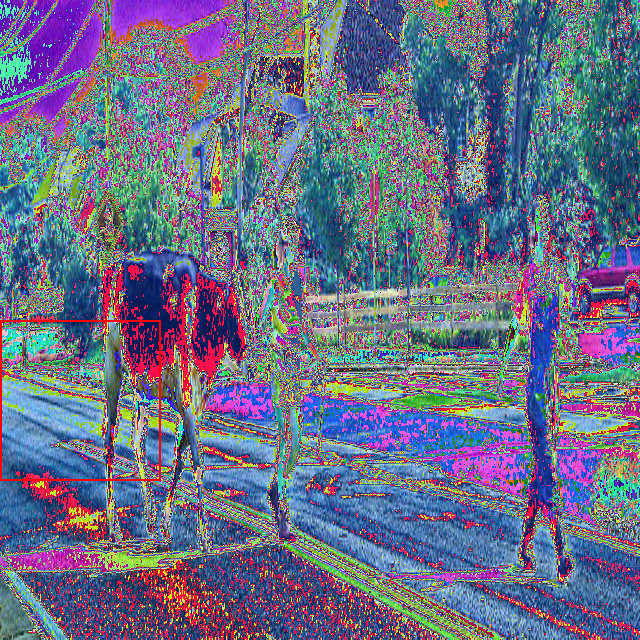

In [108]:
draw = ImageDraw.Draw(image)
draw.rectangle(list(output[0]), outline="red", width=2)

# Show the image with the bounding box
image.show()